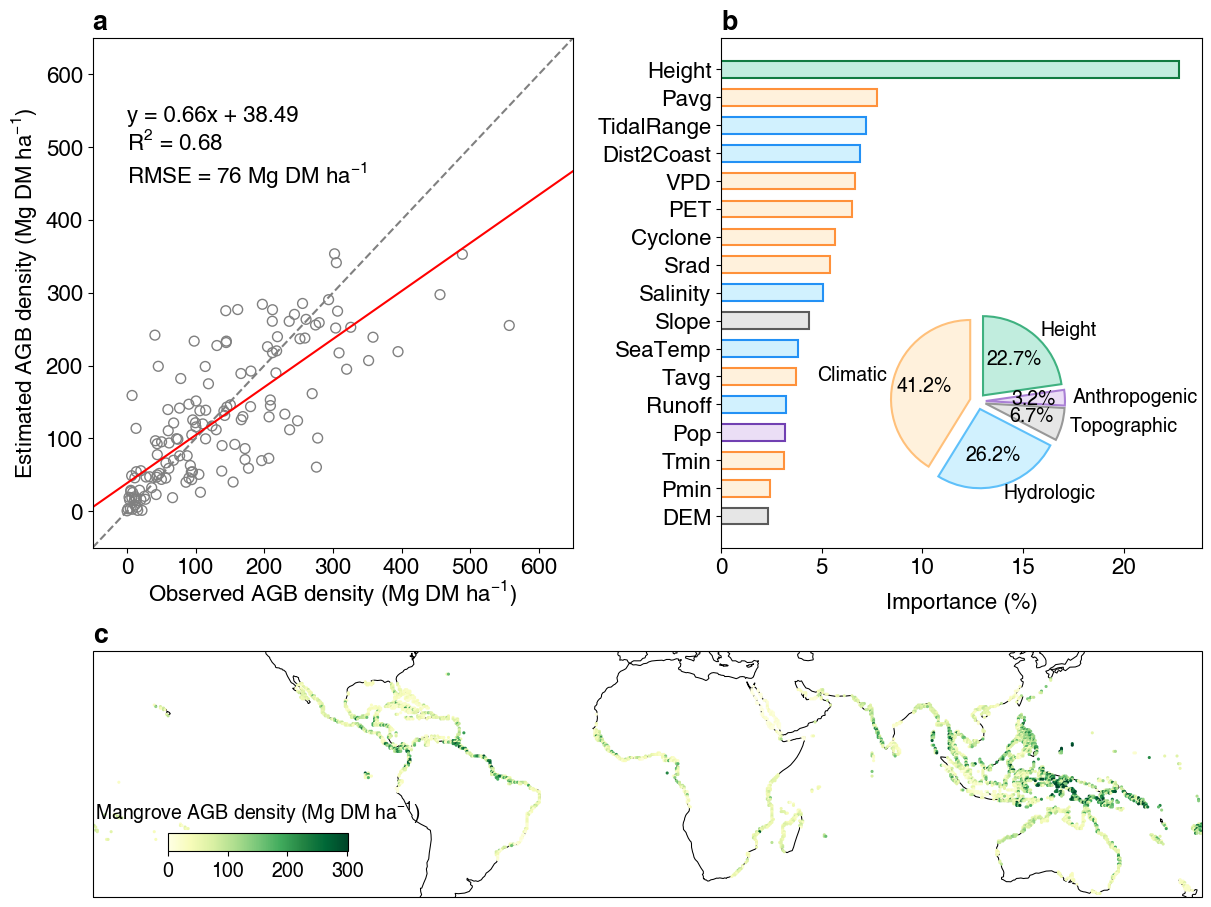

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.mathtext import _mathtext as mathtext
mathtext.FontConstantsBase.sup1 = 0.45
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

test_set_df = pd.read_pickle('../data/GB_WorldClim_Potapov/test_set.pkl')
importance_df = pd.read_pickle('../data/GB_WorldClim_Potapov/importance.pkl').sort_values('Importance', ascending=False)
map_df = pd.read_csv('../data/GB_WorldClim_Potapov/AGB_upscale_2020_GB_halfdeg.csv')

# 子图a：散点图
observed_agb = test_set_df['Observed_AGB']
estimated_agb = test_set_df['Estimated_AGB']
rmse = np.sqrt(mean_squared_error(observed_agb, estimated_agb))
r2 = r2_score(observed_agb, estimated_agb)
coefficients = np.polyfit(observed_agb, estimated_agb, 1)
polynomial = np.poly1d(coefficients)
equation = f"y = {polynomial.coefficients[0]:.2f}x + {polynomial.coefficients[1]:.2f}\nR$^2$ = {r2:.2f}\nRMSE = {rmse:.0f} Mg DM ha$^{{-1}}$"

# 子图b：重要性图
features = importance_df['Feature']
importance = importance_df['Importance']
importance_pct = (importance / importance.sum()) * 100

categories = {
    'Climatic': ['Tavg', 'Tmin', 'Pavg', 'Pmin', 'Srad', 'VPD', 'PET', 'Cyclone'],
    'Hydrologic': ['Runoff', 'TidalRange', 'Dist2Coast', 'Salinity', 'SeaTemp'],
    'Topographic': ['DEM', 'Slope'],
    'Anthropogenic': ['Pop'],
    'Height': ['Height']
}

color_map = {
    'Climatic': '#FFF1DC',
    'Hydrologic': '#D1F1FE',
    'Topographic': '#E6E6E6',
    'Anthropogenic': '#EBDEF6',
    'Height': '#C1EDDE'
}
feature_to_category = {feature: cat for cat, feats in categories.items() for feature in feats}
colors = [mcolors.hex2color(color_map[feature_to_category[feature]]) if feature in feature_to_category else 'black' for feature in features]

# 调整颜色亮度
def brighten_rgb(color, beta):
    """
    Brighten or darken a single RGB color.
    
    Parameters:
    color (tuple): A tuple representing an RGB color, e.g., (0.5, 0.2, 0.7)
    beta (float): A value to control the brightness. If 0 < beta <= 1, the color becomes brighter,
                  and if -1 <= beta < 0, it becomes darker.

    Returns:
    tuple: The adjusted RGB color.
    """
    color = np.clip(color, 0, 1)
    if beta > 0:
        gamma = 1 - min(1 - np.sqrt(np.finfo(float).eps), beta)
    else:
        gamma = 1 / (1 + max(-1 + np.sqrt(np.finfo(float).eps), beta))
    return tuple(np.clip(np.array(color) ** gamma, 0, 1))

edge_colors = [brighten_rgb(color, -0.9) for color in colors]  # 应用暗化边框颜色

# Set global font to Helvetica
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 16
# Set the mathtext font to Helvetica
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Helvetica'
plt.rcParams['mathtext.it'] = 'Helvetica:italic'
plt.rcParams['mathtext.bf'] = 'Helvetica:bold'


# 创建布局
fig = plt.figure(figsize=(12, 9), constrained_layout=True)
grid = fig.add_gridspec(2, 2, height_ratios=[1, 0.5], width_ratios=[1, 1])

# 子图a：散点图
ax1 = fig.add_subplot(grid[0, 0])
ax1.scatter(observed_agb, estimated_agb, facecolors='none', edgecolors='gray', s=50, label="Data points")
plot_range = [-50, 650]
ax1.plot(plot_range, plot_range, linestyle='--', color='gray', label="1:1 line")
ax1.plot(plot_range, polynomial(plot_range), color='red', label="Regression line")
ax1.set_xlim(plot_range)
ax1.set_ylim(plot_range)
ax1.set_xlabel("Observed AGB density (Mg DM ha$^{-1}$)", labelpad=0)
ax1.set_ylabel("Estimated AGB density (Mg DM ha$^{-1}$)")
ax1.text(0, 450, equation)
ax1.set_title('a', loc='left', fontweight='bold')

# 子图b：柱状图
ax2 = fig.add_subplot(grid[0, 1])
ax2.barh(features, importance_pct, color=colors, edgecolor=edge_colors, height=0.6, linewidth=1.5)  # 添加暗化边框
ax2.set_xlabel("Importance (%)", labelpad=10)
ax2.invert_yaxis()
ax2.set_title('b', loc='left', fontweight='bold')

# 添加饼图
pie_ax = fig.add_axes([0.70, 0.45, 0.22, 0.22])  # 控制饼图位置和大小
category_percentages = {
    cat: importance_pct[features.isin(feats)].sum() for cat, feats in categories.items()
}
pie_colors = [color_map[cat] for cat in category_percentages.keys()]
pie_edge_colors = [brighten_rgb(mcolors.hex2color(color), -0.8) for color in pie_colors]
explode = [0.1] * len(category_percentages)

wedges, texts, autotexts = pie_ax.pie(
    category_percentages.values(),
    labels=category_percentages.keys(),
    colors=pie_colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
    textprops={'fontsize': 14}
)

# 为饼图边框添加暗化颜色
for wedge, edge_color in zip(wedges, pie_edge_colors):
    wedge.set_edgecolor(edge_color)

# 子图c：地图
ax3 = fig.add_subplot(grid[1, :], projection=ccrs.PlateCarree())
ax3.coastlines(resolution='110m', linewidth=0.75, color='black', zorder=0)
ax3.set_extent([-180, 180, -40, 40], crs=ccrs.PlateCarree())
scatter = ax3.scatter(map_df['Lon'], map_df['Lat'], c=map_df['AGB'], cmap='YlGn', s=5, edgecolor='none', transform=ccrs.PlateCarree(), zorder=1)
scatter.set_clim(0, 301)
ax3.set_title('c', loc='left', fontweight='bold')

# 添加色带
cbar_ax = fig.add_axes([0.135, 0.06, 0.15, 0.02])  # 控制色带位置和大小
cbar = plt.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_title('Mangrove AGB density (Mg DM ha$^{-1}$)', fontsize=14, pad=10)
cbar.set_ticks([0, 100, 200, 300])
cbar.ax.tick_params(labelsize=14)

# 保存并展示图形
fig.savefig('../fig/py01_machine-learning_AGB.jpg', dpi=600)
plt.show()